In [36]:
import transformers as t
import datasets
from datasets import load_dataset

import torch
import torch_geometric

from torch_geometric.data import DataLoader
import torch_geometric.nn as geom_nn

import numpy as np
import pandas as pd

import spacy

import os
import json

from torch_geometric.data import Data, Dataset
from huggingface_hub import hf_hub_download

from huggingface_hub import hf_hub_url
from huggingface_hub.file_download import cached_download

In [31]:
def graphs_from_json(json_file):
    with open(json_file, "r") as f:
        graphs = json.load(f)

    dataset = []
    for graph in graphs:
        x = torch.tensor(graph['x'], dtype=torch.float).view(-1, 1)
        edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)
        y = torch.tensor(graph['y'], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        dataset.append(data)

    return dataset

In [35]:
repo_name = "FranklinWillemen/mapa_plus_graph"

# Download the JSON files
#hf_hub_download(repo_id=repo_name, repo_type="dataset", filename="graphs_train.json")
#hf_hub_download(repo_id=repo_name, repo_type="dataset", filename="graphs_val.json")
#hf_hub_download(repo_id=repo_name, repo_type="dataset", filename="graphs_test.json")

train_url = hf_hub_url(repo_name, "graphs_train.json", repo_type="dataset")
val_url = hf_hub_url(repo_name, "graphs_val.json", repo_type="dataset")
test_url = hf_hub_url(repo_name, "graphs_test.json", repo_type="dataset")

train_file = cached_download(train_url)
val_file = cached_download(val_url)
test_file = cached_download(test_url)

train_dataset = graphs_from_json(train_file)
val_dataset = graphs_from_json(val_file)
test_dataset = graphs_from_json(test_file)

In [38]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

c:\Users\Frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [39]:
class GNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = geom_nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = geom_nn.GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [40]:
input_dim = 1
hidden_dim = 16
output_dim = 1
model = GNNModel(input_dim, hidden_dim, output_dim)
criterion = torch.nn.MSELoss()  # Replace with your desired loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    # print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}")

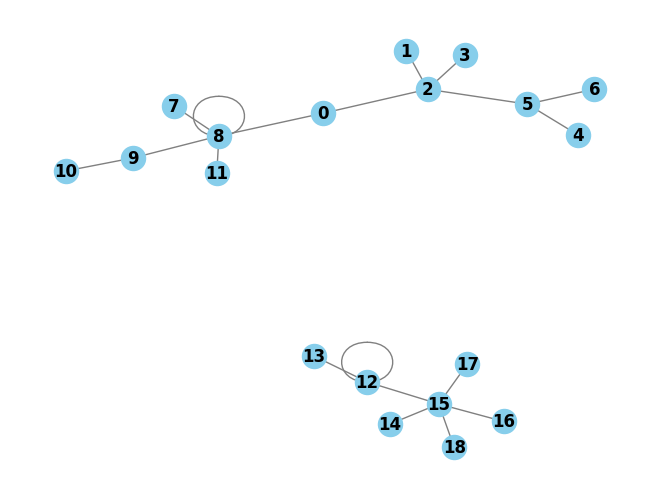

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(graph):
    # Convert PyTorch Geometric graph to a NetworkX graph
    g = nx.Graph()
    edge_index = graph.edge_index.cpu().numpy()
    for src, tgt in edge_index.T:
        g.add_edge(src, tgt)

    # Draw the graph
    pos = nx.spring_layout(g)
    nx.draw(g, pos, node_color="skyblue", edge_color="gray", with_labels=True, font_weight="bold")

    # Show the plot
    plt.show()

# Assuming you have a list of PyTorch Geometric graphs called 'graphs'
# You can visualize the first graph in the list as follows:
visualize_graph(train_dataset[0])